
[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


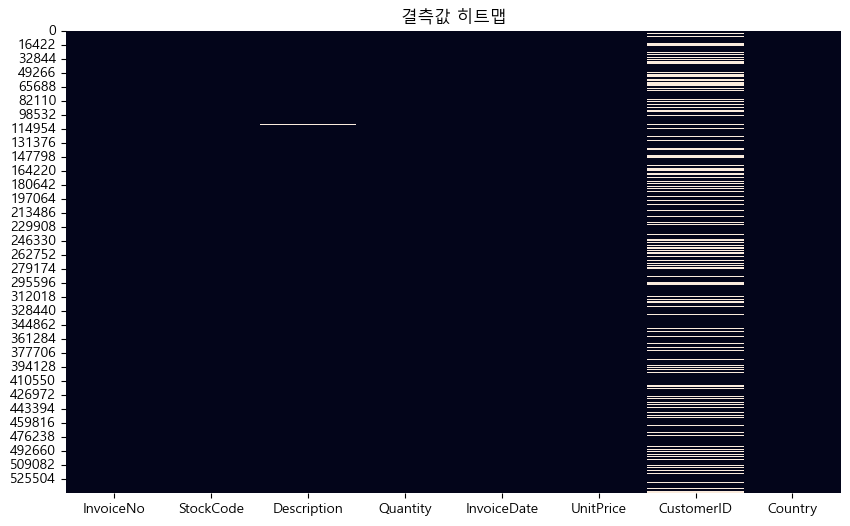

전체 거래 541909
고유 InvoiceNo 25900
고유 고객수 4372
CustomerID 결측값 제거: 135080건
취소거래 분리: 8905건
정상 거래: 397924건

=== 이상값 확인 ===
음수 수량: 0
음수 단가: 0
0 단가: 40
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
 8   TotalAmount  397884 non-null  float64       
 9   Year         397884 non-null  int32         
 10  Month        397884 non-null  int32         
 11  DayOfWeek    397884 non-null  int32         
 12  Hour         397884 non-null  int32         


In [25]:
%pip install -q kagglehub[pandas-datasets]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('./OnlineRetail.csv', encoding='ISO-8859-1')

# da_utils 모듈이 없으므로 아래 코드 주석 처리
# from da_utils import profile, outliers, patterns
# profile.get_data_profile(df)
# patterns.analyze_missing_patterns(df)
# outliers.outlier_detection(df, 0.999, iso_cont='auto', final_threshold=2)

# 기본 데이터 프로파일링
print(df.info())
print(df.isnull().sum())
display(df.describe())

# 결측값 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('결측값 히트맵')
plt.show()

print("전체 거래", len(df))
print("고유 InvoiceNo", df["InvoiceNo"].nunique())
print("고유 고객수", df["CustomerID"].nunique())

# 데이터 전처리
df_clean = df.copy()

# CustomerID 결측값 제거 (고객 단위 분석을 위해 필수)
missing_customers = df_clean["CustomerID"].isnull().sum()
print(f"CustomerID 결측값 제거: {missing_customers}건")
df_clean = df_clean.dropna(subset=["CustomerID"])

# 취소 거래 분리 (InvoiceNo 가 'C' 로 시작)
cancel_mask = df_clean["InvoiceNo"].astype(str).str.startswith("C")
df_cancel = df_clean[cancel_mask]
df_clean = df_clean[~cancel_mask]
print(f"취소거래 분리: {len(df_cancel)}건")
print(f"정상 거래: {len(df_clean)}건")

# 파생 변수 생성
df_clean["CustomerID"] = df_clean["CustomerID"].astype(int).astype(str)
df_clean["TotalAmount"] = df_clean["Quantity"] * df_clean["UnitPrice"]
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])
df_clean["Year"] = df_clean["InvoiceDate"].dt.year
df_clean["Month"] = df_clean["InvoiceDate"].dt.month
df_clean["DayOfWeek"] = df_clean["InvoiceDate"].dt.dayofweek
df_clean["Hour"] = df_clean["InvoiceDate"].dt.hour
df_clean["DayName"] = df_clean["InvoiceDate"].dt.day_name()

print("\n=== 이상값 확인 ===")
print(f"음수 수량: {(df_clean['Quantity'] < 0).sum()}")
print(f"음수 단가: {(df_clean['UnitPrice'] < 0).sum()}")
print(f"0 단가: {(df_clean['UnitPrice'] == 0).sum()}")

# 양수 수량 & 양수 단가 데이터만 살리기
# 양수 수량 & 양수 단가 데이터만 살리기
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["UnitPrice"] > 0)]

df_clean.info()

In [26]:
print('=== 고객별 구매 패턴 특성 DF 생성 ===')

customer_stats = df_clean.groupby('CustomerID').agg({
    'InvoiceNo':  'nunique',  # 구매 횟수(Frequency)
    'Quantity': ['sum', 'mean'],  # 총구매량, 평균구매량
    'UnitPrice': 'mean',  # 평균 단가
    'TotalAmount': ['sum', 'mean'],  # 총 구매액(Monetary), 평균 구매액
    'StockCode': 'nunique',  # 구매한 상품 종류 수
    'InvoiceDate': ['min', 'max'],  # 첫 구매일, 마지막 구매일
}).round(2)

# 컬럼명 정리 (구매횟수==F, 총구매액==M)
customer_stats.columns = ['Frequency', '총구매량', '평균구매량', '평균단가', 
                        'Monetary', '평균구매액', '상품종류수', '첫구매일', '마지막구매일']

# 구매 기간 및 주기 계산 (추가하기)
customer_stats['구매기간일수'] = (customer_stats['마지막구매일'] - customer_stats['첫구매일']).dt.days + 1
customer_stats['구매주기'] = customer_stats['구매기간일수'] / customer_stats['Frequency']

# RFM 분석 변수
analysis_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
customer_stats['Recency'] = (analysis_date - customer_stats['마지막구매일']).dt.days


# RFM점수 (모두 5등급) (.qcut으로 5등분)
customer_stats['R_score'] = pd.qcut(customer_stats['Recency'], 5, labels=[5,4,3,2,1])
customer_stats['F_score'] = pd.qcut(customer_stats['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
customer_stats['M_score'] = pd.qcut(customer_stats['Monetary'], 5, labels=[1,2,3,4,5])
customer_stats['RFM_score'] = (customer_stats['R_score'].astype(str) + \
                                customer_stats['F_score'].astype(str) + \
                                customer_stats['M_score'].astype(str))
# 추가정보
customer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['Frequency']
customer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['Frequency']

# 가격 민감도 - 단가가 상대적으로 일관되게 유지되는가?
# CV = Coefficient of Variation (표준편차 / 평균) => 높으면, 다양한 가격대로 산다 / 낮으면, 특정 가격대에 고정적 구매
price_cv = df_clean.groupby('CustomerID')['UnitPrice'].agg(['mean', 'std'])
price_cv['가격변동성'] = (price_cv['std'] / price_cv['mean']).fillna(0)

customer_stats = customer_stats.merge(
    price_cv[['가격변동성']], # 두 DF 다 컬럼이 아닌 인덱스가 CustomerID
    left_index=True,   # customer_stats의 인덱스 기준으로 병합
    right_index=True   # price_cv의 인덱스 기준으로 병합
)

customer_stats

=== 고객별 구매 패턴 특성 DF 생성 ===


,Frequency,총구매량,평균구매량,평균단가,Monetary,평균구매액,상품종류수,첫구매일,마지막구매일,구매기간일수,구매주기,Recency,R_score,F_score,M_score,RFM_score,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1.000000,326,1,1,5,115,74215.000000,1.000000,0.000000
12347,7,2458,13.51,2.64,4310.00,23.68,103,2010-12-07 14:57:00,2011-12-07 15:52:00,366,52.285714,2,5,5,5,555,351.142857,14.714286,0.853015
12348,4,2341,75.52,5.76,1797.24,57.98,22,2010-12-16 19:09:00,2011-09-25 13:13:00,283,70.750000,75,2,4,4,244,585.250000,5.500000,2.324492
12349,1,631,8.64,8.29,1757.55,24.08,73,2011-11-21 09:51:00,2011-11-21 09:51:00,1,1.000000,19,4,1,4,414,631.000000,73.000000,4.225823
12350,1,197,11.59,3.84,334.40,19.67,17,2011-02-02 16:01:00,2011-02-02 16:01:00,1,1.000000,310,1,1,2,112,197.000000,17.000000,2.430180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,1,45,4.50,4.76,180.60,18.06,10,2011-03-07 09:52:00,2011-03-07 09:52:00,1,1.000000,278,1,2,1,121,45.000000,10.000000,0.518798
18281,1,54,7.71,5.62,80.82,11.55,7,2011-06-12 10:53:00,2011-06-12 10:53:00,1,1.000000,181,1,2,1,121,54.000000,7.000000,1.383397
18282,2,103,8.58,5.20,178.05,14.84,12,2011-08-05 13:35:00,2011-12-02 11:43:00,119,59.500000,8,5,3,1,531,51.500000,6.000000,0.937819


In [27]:
print('=== 기본 상관관계 분석 ===')

numeric_cols =  ['Frequency', '총구매량', '평균구매량', '평균단가', 'Monetary', 
                   '평균구매액', '상품종류수', '구매기간일수', '구매주기', 'Recency', 
                   'Frequency', 'Monetary', '평균장바구니크기', '거래당상품종류', '가격변동성']
correlation_data= customer_stats[numeric_cols]
correlation_data.head(3)

=== 기본 상관관계 분석 ===


,Frequency,총구매량,평균구매량,평균단가,Monetary,평균구매액,상품종류수,구매기간일수,구매주기,Recency,Frequency,Monetary,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,1,1.000000,326,1,77183.60,74215.000000,1.000000,0.000000
12347,7,2458,13.51,2.64,4310.00,23.68,103,366,52.285714,2,7,4310.00,351.142857,14.714286,0.853015
12348,4,2341,75.52,5.76,1797.24,57.98,22,283,70.750000,75,4,1797.24,585.250000,5.500000,2.324492


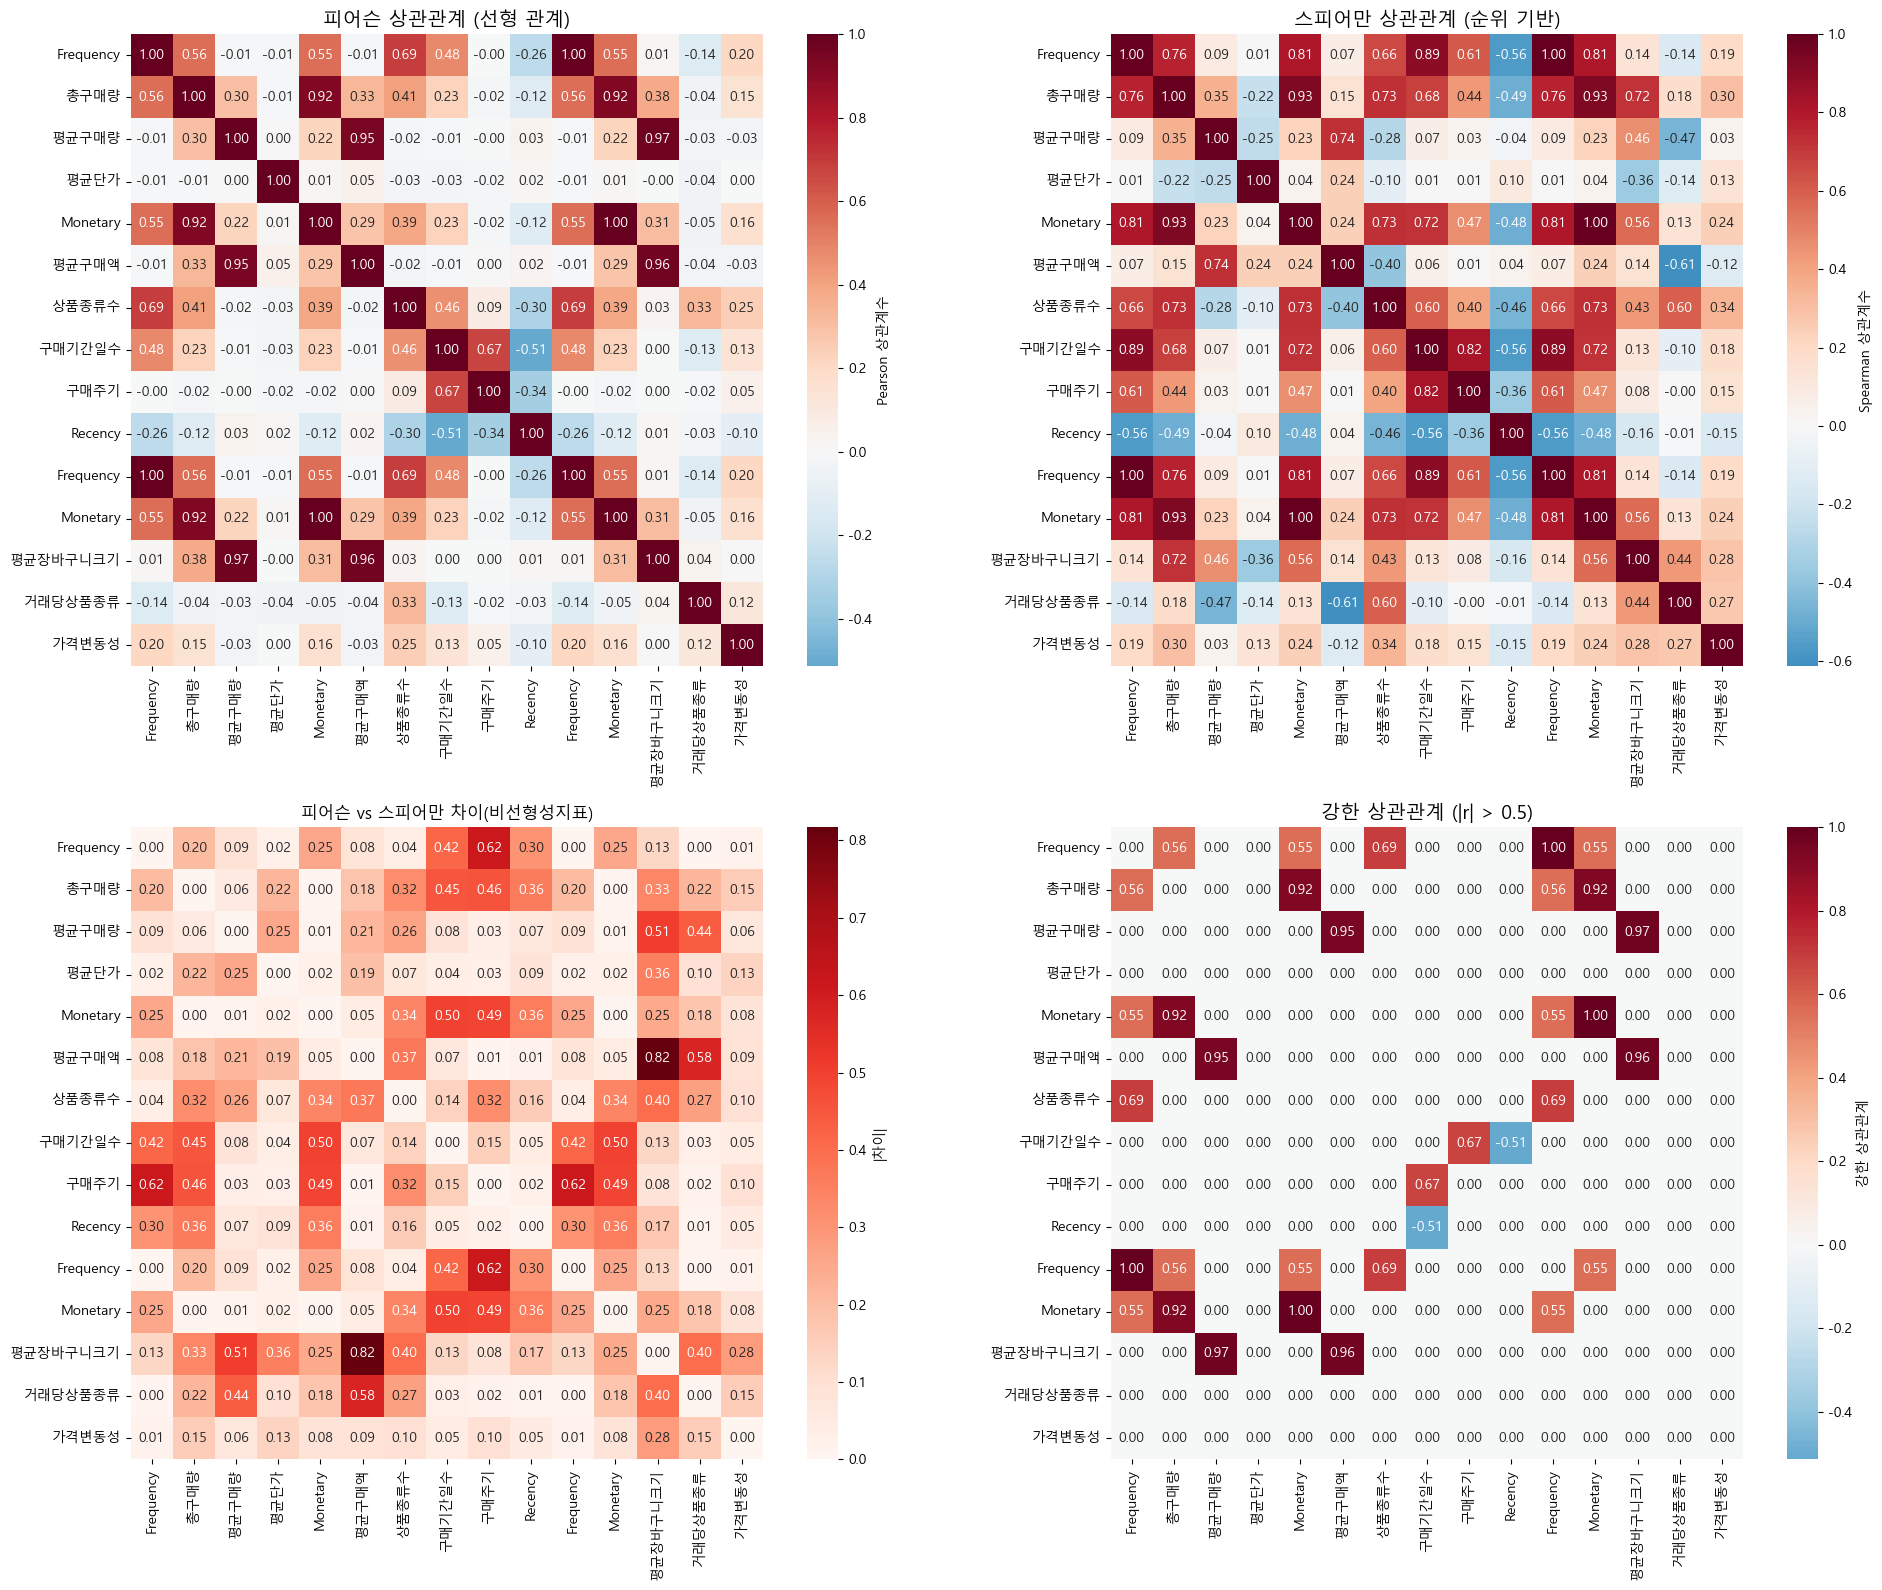

In [28]:
# 피어슨 상관관계 -키<-> 몸무게 / 온도 <->전력 같이 실제 값이 비례하는 경우 (값)
pearson_corr = correlation_data.corr(method='pearson')
# 스피어만 상관관계 - 시험순위<->대회순위 / 만족도<->재구매의사 같이 서열형 관계에 적합 (순서)
spearman_corr = correlation_data.corr(method='spearman')

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

# 피어슨 상관관계 히트맵    
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a1, cbar_kws={'label': 'Pearson 상관계수'})
a1.set_title('피어슨 상관관계 (선형 관계)', fontsize=14)

# 스피어만 상관관계 히트맵
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a2, cbar_kws={'label': 'Spearman 상관계수'})
a2.set_title('스피어만 상관관계 (순위 기반)', fontsize=14)

corr_diff = abs(spearman_corr - pearson_corr)
sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='Reds',
             square=True, ax=a3, cbar_kws={'label': '|차이|'})
a3.set_title('피어슨 vs 스피어만 차이(비선형성지표)')

#강한 상관관계 (|r| > 0.5) 네트워크
strong_corr = pearson_corr.copy()
strong_corr[abs(strong_corr) < 0.5] = 0

np.fill_diagonal(strong_corr.values, 0)
sns.heatmap(strong_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a4, cbar_kws={'label': '강한 상관관계'})
a4.set_title('강한 상관관계 (|r| > 0.5)', fontsize=14)
    
plt.tight_layout()
plt.show()

In [29]:
# 주요 발견사항 요약
print('\n=== 주요 상관관계 발견사항 ===')
# 아래 히트맵에서 위쪽 삼각형만 보겠다
upper_triangle = np.triu(pearson_corr, k=1)
# 가장 큰 값이 있는 인덱스
strong_positive = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
# 가장 강한 양의 상관관계
max_corr = pearson_corr.iloc[strong_positive]
print(f'가장 강한 양의 상관 관계: {max_corr:.3f}')
print(f'  {pearson_corr.index[strong_positive[0]]} <-> {pearson_corr.index[strong_positive[1]]}')

strong_negative = np.unravel_index(np.argmin(upper_triangle), upper_triangle.shape)
min_corr = pearson_corr.iloc[strong_negative]

print(f'가장 강한 음의 상관 관계: {min_corr:.3f}')
print(f'  {pearson_corr.index[strong_negative[0]]} <-> {pearson_corr.index[strong_negative[1]]}')


=== 주요 상관관계 발견사항 ===
가장 강한 양의 상관 관계: 1.000
  Frequency <-> Frequency
가장 강한 음의 상관 관계: -0.514
  구매기간일수 <-> Recency


In [39]:
print('매출 증대 핵심 요인')
monetary_corr = pearson_corr['Monetary'].abs().sort_values(ascending=False)
for factor, corr in monetary_corr.head(6).items():
    if factor != 'Monetary':
        print(f'  {factor}: {corr:.3f}')


print('\n고객 충성도 관련 요인')
frequency_corr = pearson_corr['Frequency'].abs().sort_values(ascending=False)
for factor, corr in frequency_corr.head(6).items():
    if factor != 'Frequency':
        print(f'  {factor}: {corr:.3f}')

매출 증대 핵심 요인


TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

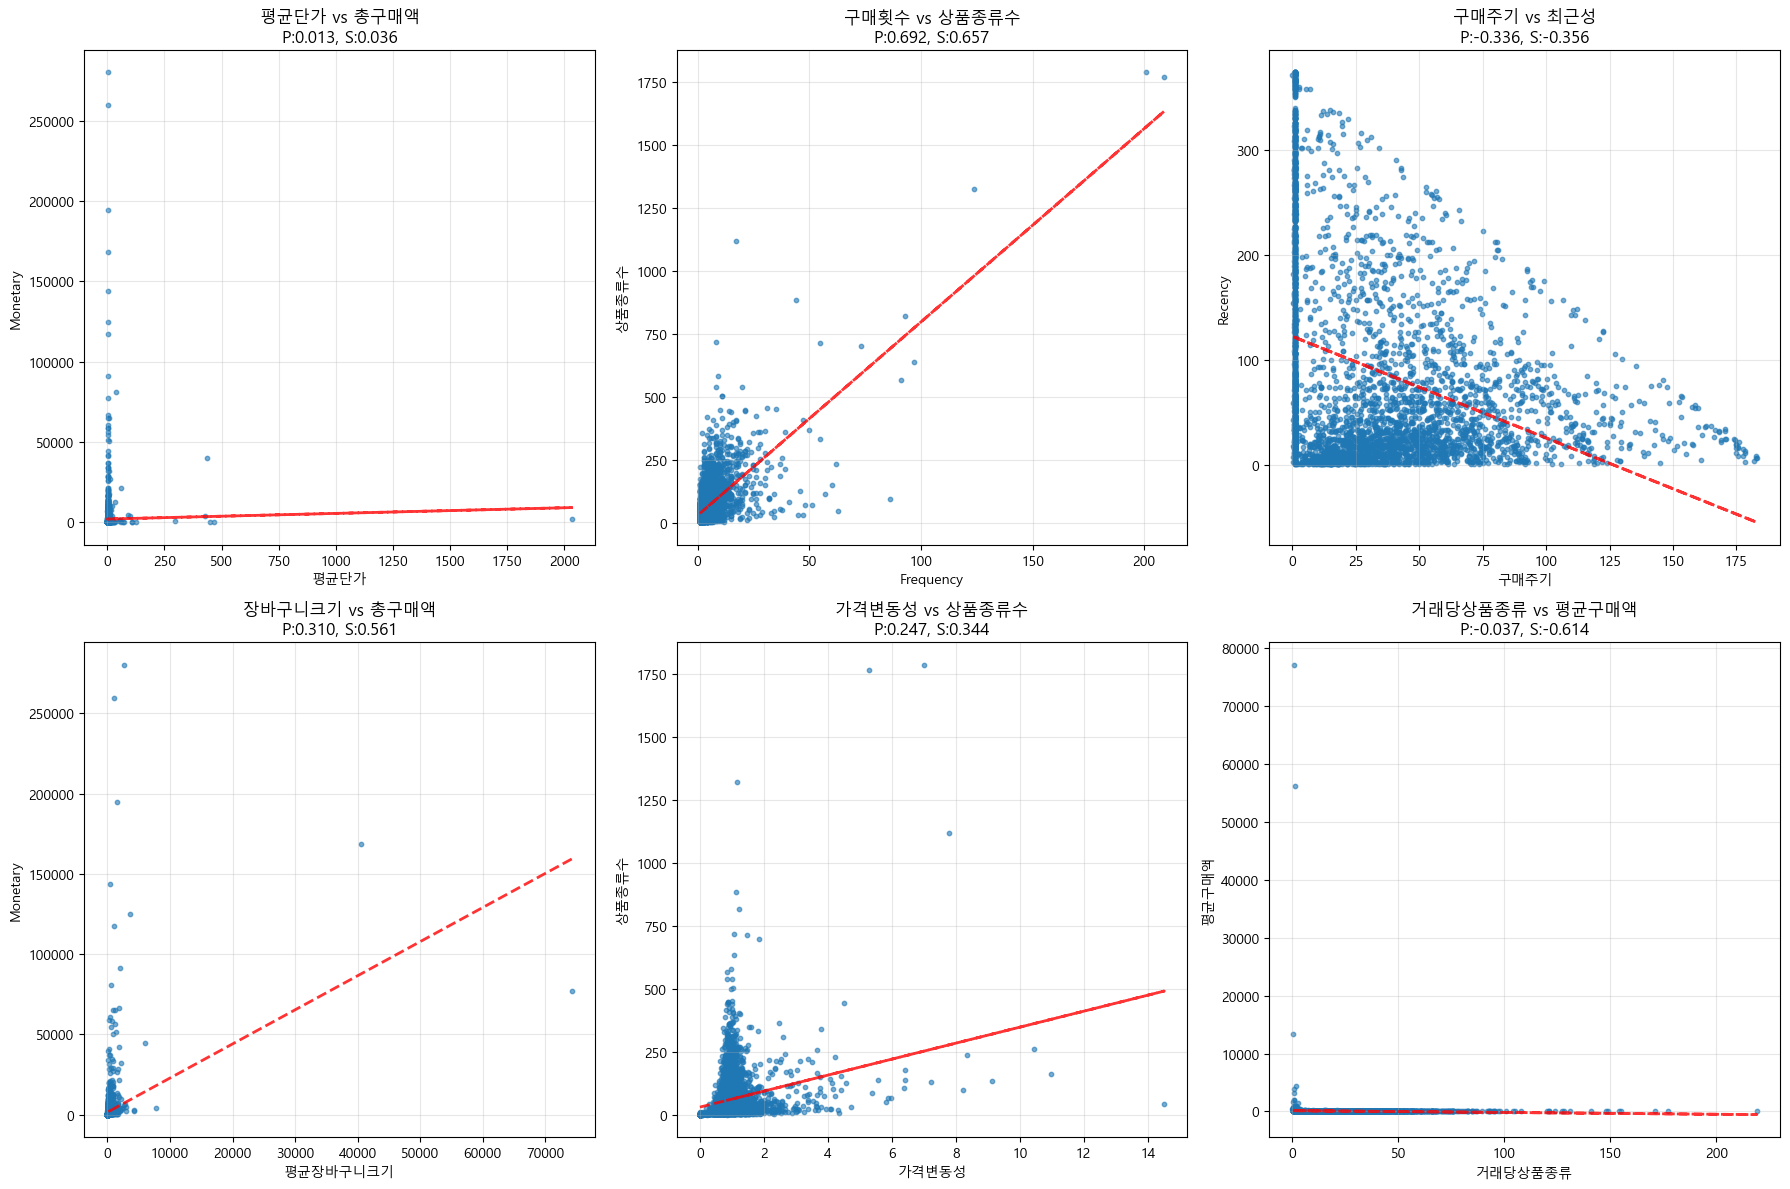

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# 그래프 2차원 리스트 -> 1차원으로 평탄화
axes = axes.ravel()

relationships = [
    ('평균단가', 'Monetary', '평균단가 vs 총구매액'),
    ('Frequency', '상품종류수', '구매횟수 vs 상품종류수'),
    ('구매주기', 'Recency', '구매주기 vs 최근성'), 
    ('평균장바구니크기', 'Monetary', '장바구니크기 vs 총구매액'),
    ('가격변동성', '상품종류수', '가격변동성 vs 상품종류수'),
    ('거래당상품종류', '평균구매액', '거래당상품종류 vs 평균구매액')
]

for idx, (x, y, title) in enumerate(relationships):
    # 산점도 
    axes[idx].scatter(customer_stats[x], customer_stats[y], alpha=0.6, s=10)
    # 선형 회귀선(트렌드라인)
    z = np.polyfit(customer_stats[x], customer_stats[y], 1)  # 1-> 1차함수로 뽑아라
    # 데이터별 1차함수
    p = np.poly1d(z)
    axes[idx].plot(customer_stats[x], p(customer_stats[x]), 'r--', alpha=0.8, linewidth=2)
    
    pearson_r = customer_stats[x].corr(customer_stats[y], method='pearson')
    spearman_r = customer_stats[x].corr(customer_stats[y], method='spearman')

    axes[idx].set_xlabel(x)
    axes[idx].set_ylabel(y)
    axes[idx].set_title(f'{title}\nP:{pearson_r:.3f}, S:{spearman_r:.3f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
# 고급 상관관계 측정
print('==고급 상관관계 측정===')

# 핵심 변수(칼럼)들 선택
key_vars = ['Monetary', 'Frequency', 'Recency', '평균단가', '상품종류수', '평균장바구니크기']
analysis_data = customer_stats[key_vars].copy()

from scipy.stats import kendalltau
# 켄달 타우 상관계수 (순위기반- 이상값에 강함)
print('1.켄달 타우 상관계수 분석')
kendall_results = {}

for idx, var in enumerate(key_vars):
    for var2 in key_vars[idx+1:]:
        tau = analysis_data[var].corr(analysis_data[var2], method='kendall')
        kendall_results[f'{var} vs {var2}'] = tau

print(kendall_results)

==고급 상관관계 측정===
1.켄달 타우 상관계수 분석
{'Monetary vs Frequency': np.float64(0.6565461470377415), 'Monetary vs Recency': np.float64(-0.3352503736274444), 'Monetary vs 평균단가': np.float64(0.02376396795653992), 'Monetary vs 상품종류수': np.float64(0.5547905679453158), 'Monetary vs 평균장바구니크기': np.float64(0.39554574483569255), 'Frequency vs Recency': np.float64(-0.4251229679466637), 'Frequency vs 평균단가': np.float64(0.006436138547647394), 'Frequency vs 상품종류수': np.float64(0.5051404197633652), 'Frequency vs 평균장바구니크기': np.float64(0.10087103885781905), 'Recency vs 평균단가': np.float64(0.06876049436473702), 'Recency vs 상품종류수': np.float64(-0.31764897172014134), 'Recency vs 평균장바구니크기': np.float64(-0.1070005560217046), '평균단가 vs 상품종류수': np.float64(-0.07189893187273151), '평균단가 vs 평균장바구니크기': np.float64(-0.25135474103320704), '상품종류수 vs 평균장바구니크기': np.float64(0.29966563648571415)}


In [42]:
# 고급 상관관계 측정
print('=== 고급 상관관계 측정 ===')

# 핵심 변수(컬럼)들 선택
key_vars = ['Monetary', 'Frequency', 'Recency', '평균단가', '상품종류수', '평균장바구니크기']
analysis_data = customer_stats[key_vars].copy()

kendall_results = {}

'''
켄달 타우 vs 스피어만 - 둘다 순위 기반
켄달타우: 데이터 개수가 적거나 순위 정보만 확실한 경우, 이상치가 있거나 동점자가 많은 경우
스피어만: 연속형 데이터지만, 선형이 아닐 때, 이상치가 없고 동점자가 적은 경우
'''
from scipy.stats import kendalltau
# 켄달 타우 상관계수 (순위기반 - 이상값에 강함)
print('1. 켄달 타우 상관계수 분석')
for idx, var1 in enumerate(key_vars):
    for var2 in key_vars[idx+1:]:
        tau, p_value = kendalltau(analysis_data[var1], analysis_data[var2])
        # 켄달 타우 결과 확인(유의미한 관계만 -> p_value < 0.05)
        if p_value < 0.05 and abs(tau) > 0.1:
            kendall_results[f'{var1} vs {var2}'] = {'tau': tau, 'p_value': p_value}

for rel, stats in kendall_results.items():
    print(f'  {rel} = {stats['tau']:.3f} (p={stats['p_value']:.3f})')

=== 고급 상관관계 측정 ===
1. 켄달 타우 상관계수 분석
  Monetary vs Frequency = 0.657 (p=0.000)
  Monetary vs Recency = -0.335 (p=0.000)
  Monetary vs 상품종류수 = 0.555 (p=0.000)
  Monetary vs 평균장바구니크기 = 0.396 (p=0.000)
  Frequency vs Recency = -0.425 (p=0.000)
  Frequency vs 상품종류수 = 0.505 (p=0.000)
  Frequency vs 평균장바구니크기 = 0.101 (p=0.000)
  Recency vs 상품종류수 = -0.318 (p=0.000)
  Recency vs 평균장바구니크기 = -0.107 (p=0.000)
  평균단가 vs 평균장바구니크기 = -0.251 (p=0.000)
  상품종류수 vs 평균장바구니크기 = 0.300 (p=0.000)


In [43]:
# 상호 정보량 (Mutual Information) 기반 분석
# 선형, 비선형 구분없이 변수간 정보량 공유 정도를 측정
# MI = 0 -> 전혀 관련 없음
# MI >= 1 -> 꽤 관련 있음
# MI > 큼 -> 변수 X는 변수Y 예측에 유용하다

# 켄달타우 -> '방향'과 '순위'의 일관성
# MI 점수 -> '관계'가 있긴한데, +- 몰라, 그냥 둘이 강하게 연결 되어있는거냐


from sklearn.feature_selection import mutual_info_regression
print('2. 상호정보량 기반 연관성 (Monetary 기준)')
# Monetary를 타겟으로한 상호 정보량 계산
target = analysis_data['Monetary']
features = analysis_data.drop('Monetary', axis=1)
mi_scores = mutual_info_regression(features, target, random_state=42)
mi_results = pd.DataFrame({
    'Feature': features.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

for _, row in mi_results.iterrows():
    print(f'  {row['Feature']}: {row['MI_Score']:.3f}')

2. 상호정보량 기반 연관성 (Monetary 기준)
  Frequency: 0.554
  상품종류수: 0.516
  평균장바구니크기: 0.237
  Recency: 0.138
  평균단가: 0.057


In [44]:
# 3. 조건부 상관관계 분석 (고객 세그먼트별) - VIP, 일반, 신규

customer_stats['Segment'] = 'Regular'

vip_mask = (
            (customer_stats['R_score'].astype(int) >= 4) &
            (customer_stats['F_score'].astype(int) >= 4) &
            (customer_stats['M_score'].astype(int) >= 4)
        )
customer_stats.loc[vip_mask, 'Segment'] = 'VIP'

new_mask = customer_stats['Frequency'] == 1
customer_stats.loc[new_mask, 'Segment'] = 'New'

segments = ['VIP', 'Regular', 'New']
segment_corrs = {}

for seg in segments:
    seg_data = customer_stats[customer_stats['Segment'] == seg]
    if len(seg_data) > 10:
        # 세그먼트 별로 F <P> M
        corr = seg_data['상품종류수'].corr(seg_data['Monetary'])
        segment_corrs[seg] = {
            'corr': corr,
            'size': len(seg_data)
        }
        print(f'  {seg} 고객: M - F = {corr:.3f}, (n={len(seg_data)})')
    

  VIP 고객: M - F = 0.371, (n=962)
  Regular 고객: M - F = 0.086, (n=1883)
  New 고객: M - F = 0.068, (n=1493)


In [45]:
s = pd.Series([1, 1, 1, 1, 1, 2, 3, 4])

pd.qcut(s, q=4, duplicates='drop')

0    (0.999, 2.25]
1    (0.999, 2.25]
2    (0.999, 2.25]
3    (0.999, 2.25]
4    (0.999, 2.25]
5    (0.999, 2.25]
6      (2.25, 4.0]
7      (2.25, 4.0]
dtype: category
Categories (2, interval[float64, right]): [(0.999, 2.25] < (2.25, 4.0]]

U자형 관계 탐지
   가격변동성 상위 10% 고객 특성:
   - 평균 상품종류수: 76.8개
   - 평균 총구매액: 3,897원
   - 평균 구매횟수: 5.6회


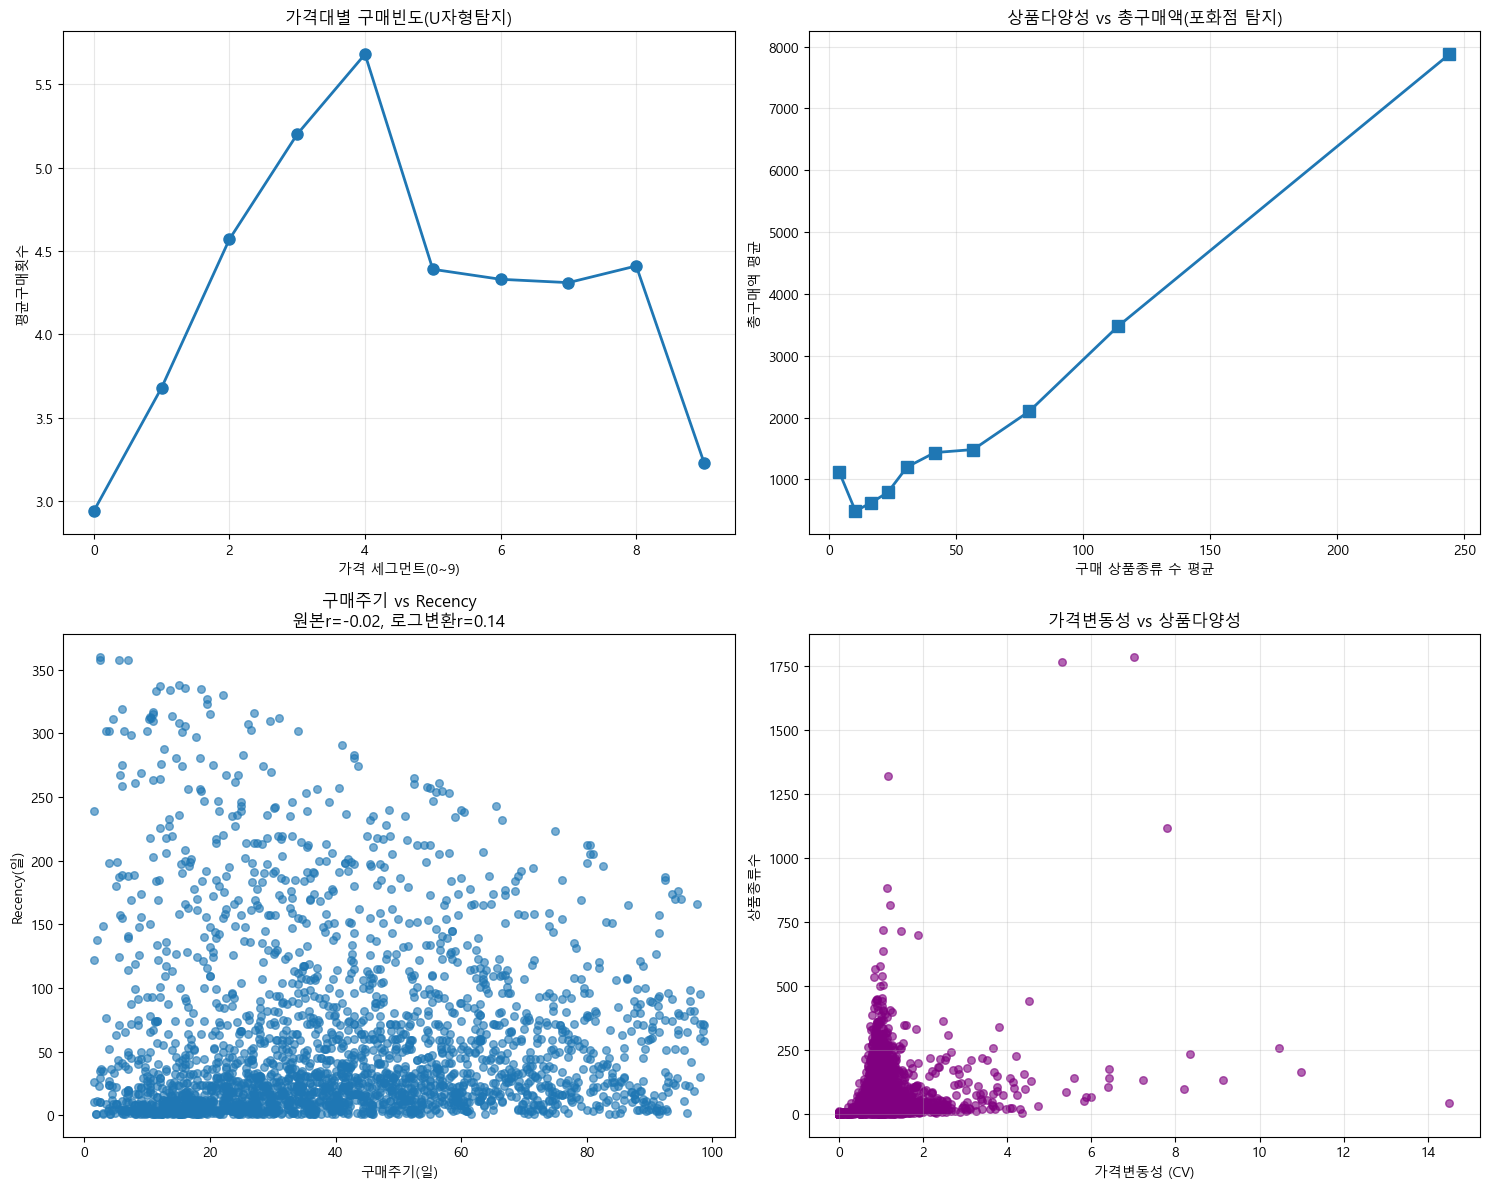

In [46]:
# 비선형 패턴 심화

print('U자형 관계 탐지')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
a1, a2, a3, a4 = axes.ravel()

# 평균 단가 구간별 구매횟수 분석
customer_stats['Price_Segment'] = pd.qcut(customer_stats['평균단가'], q=10, labels=False, duplicates='drop')

price_freq_analysis = customer_stats.groupby('Price_Segment').agg({
    'Frequency': ['mean', 'count'],
    '평균단가': 'mean',
    'Monetary': 'mean'
}).round(2)

price_freq_analysis.columns = ['평균구매횟수', '고객수', '평균단가', '평균총구매액']

# X축 - 세그먼트, Y축 평균구매횟수(나머지 컬럼들도 세팅 가능)
a1.plot(price_freq_analysis.index, price_freq_analysis['평균구매횟수'], marker='o', linewidth=2, markersize=8)
a1.set_xlabel('가격 세그먼트(0~9)')
a1.set_ylabel('평균구매횟수')
a1.set_title('가격대별 구매빈도(U자형탐지)')
a1.grid(True, alpha=0.3)

# 구매 상품 다양성 <-> 총구매액
customer_stats['Variety_Segment'] = pd.qcut(customer_stats['상품종류수'], q=10, labels=False, duplicates='drop')

variety_analysis = customer_stats.groupby('Variety_Segment').agg({
    'Monetary': 'mean',
    '평균구매액': 'mean',
    '상품종류수': 'mean',
}).round(2)

a2.plot(variety_analysis['상품종류수'], variety_analysis['Monetary'], marker='s', linewidth=2, markersize=8)
a2.set_xlabel('구매 상품종류 수 평균')
a2.set_ylabel('총구매액 평균')
a2.set_title('상품다양성 vs 총구매액(포화점 탐지)')
a2.grid(True, alpha=0.3)


# 3. 구매주기와 Recency의 관계 (지수적 관계 확인용)
# 정상적인 구매
valid_cycle = customer_stats[customer_stats['구매주기'] < customer_stats['구매주기'].quantile(0.95)]
valid_cycle = valid_cycle[valid_cycle['구매주기'] > 1]

a3.scatter(valid_cycle['구매주기'], valid_cycle['Recency'], alpha=0.6, s=30)

a3.set_xlabel('구매주기(일)')
a3.set_ylabel('Recency(일)')

# 로그 변환 선형화
log_cycle = pd.Series(np.log1p(valid_cycle['구매주기']))
log_recency = pd.Series(np.log1p(valid_cycle['Recency']))

original_corr = valid_cycle['구매주기'].corr(valid_cycle['Recency'])
log_corr = log_cycle.corr(log_recency)
a3.set_title(f'구매주기 vs Recency\n원본r={original_corr:.2f}, 로그변환r={log_corr:.2f}')


# 가격변동성과 상품종류수 관계
a4.scatter(customer_stats['가격변동성'], customer_stats['상품종류수'], 
                    alpha=0.6, s=30, color='purple')

# 가격변동성이 높은 고객들의 특성
high_variation = customer_stats['가격변동성'] > customer_stats['가격변동성'].quantile(0.9)

print(f"   가격변동성 상위 10% 고객 특성:")
print(f"   - 평균 상품종류수: {customer_stats[high_variation]['상품종류수'].mean():.1f}개")
print(f"   - 평균 총구매액: {customer_stats[high_variation]['Monetary'].mean():,.0f}원")
print(f"   - 평균 구매횟수: {customer_stats[high_variation]['Frequency'].mean():.1f}회")

a4.set_xlabel('가격변동성 (CV)')
a4.set_ylabel('상품종류수')
a4.set_title('가격변동성 vs 상품다양성')
a4.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [47]:
print('=== 범주형 변수 연관성 분석 ===')

print('1. 국가별 구매 패턴 분석')
# 구매 횟수 많은 상위 10개국
country_counts = df_clean['Country'].value_counts().head(10)
major_countries = country_counts.index.to_list()
df_major = df_clean[df_clean['Country'].isin(major_countries)].copy()

# 국가별 집계 분석
country_analysis = df_major.groupby('Country').agg({
    'TotalAmount': ['sum', 'mean', 'count'],
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique'
}).round(2)

country_analysis.columns = ['총매출', '평균거래액', '거래수', '평균수량', '평균단가', '고객수']
country_analysis['고객당매출'] = (country_analysis['총매출'] / country_analysis['고객수']).round(2)

print('주요 국가별 구매 지표')
display(country_analysis.sort_values('총매출', ascending=False))

# 2. 시간대별 구매 패턴 분석
print('\n 시간대별 구매 패턴')
hourly_analysis = df_clean.groupby('Hour').agg({
    'TotalAmount': ['sum', 'mean', 'count'],
    'CustomerID': 'nunique',
}).round(2)

hourly_analysis.columns = ['총매출', '평균거래액', '거래수', '고객수']
peak_hours = hourly_analysis.nlargest(3, '거래수')
print('거래량 상위 3개 시간대')
for hour in peak_hours.index:
    print(f'  {hour}시: {peak_hours.loc[hour, '거래수']}건')


# 3. 요일별 구매 패턴
print('\n 요일별 구매 패턴')
daily_analysis = df_clean.groupby('DayName').agg({
    'TotalAmount': ['sum', 'mean'],
    'Quantity': 'sum',
    'CustomerID': 'nunique',
}).round(2)

daily_analysis.columns = ['총매출', '평균거래액', '총수량', '고객수']
# 요일 순서 정렬 (인덱스 재정렬)

# nlargest 총매출로 가장 많이 팔리는 요일 3개 분석
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
daily_analysis = daily_analysis.reindex(day_order)
peak_days = daily_analysis.nlargest(3, '총매출')

for day in peak_days.index:
    print(f'  {day}: {peak_days.loc[day, '총매출']}원')
print('요일별 매출 현황')
display(daily_analysis)

=== 범주형 변수 연관성 분석 ===
1. 국가별 구매 패턴 분석
주요 국가별 구매 지표


,총매출,평균거래액,거래수,평균수량,평균단가,고객수,고객당매출
Country,,,,,,,
United Kingdom,7308391.55,20.63,354321,12.01,2.96,3920,1864.39
Netherlands,285446.34,121.00,2359,84.93,2.65,9,31716.26
EIRE,265545.90,36.70,7236,19.39,4.45,3,88515.30
Germany,228867.14,25.32,9040,13.19,3.71,94,2434.76
France,209024.05,25.06,8341,13.36,4.42,87,2402.58
Australia,138521.31,117.19,1182,70.98,3.06,9,15391.26
Spain,61577.11,24.79,2484,11.25,3.83,30,2052.57
Switzerland,56443.95,30.66,1841,16.34,3.47,21,2687.81
Belgium,41196.34,20.28,2031,11.44,3.63,25,1647.85



 시간대별 구매 패턴
거래량 상위 3개 시간대
  12시: 72065건
  13시: 64026건
  14시: 54118건

 요일별 구매 패턴
  Thursday: 1976859.07원
  Tuesday: 1700634.63원
  Wednesday: 1588336.17원
요일별 매출 현황


,총매출,평균거래액,총수량,고객수
DayName,,,,
Monday,1367146.41,21.07,769001,1595
Tuesday,1700634.63,25.58,1007859,1701
Wednesday,1588336.17,23.06,962417,1778
Thursday,1976859.07,24.70,1151845,2007
Friday,1485917.40,27.10,810218,1557
Sunday,792514.22,12.63,466472,1225


In [ ]:
from scipy.stats import chi2_contingency

# 카이제곱 검정과 Cramer's V 분석
print('=== 카이제곱 검정 & Cramer\'s V 분석 ===')

df_analysis = df_major.copy()

# 범주형 변수로 변환

# 거래액 구간화
df_analysis['Amount_Cateogry'] = pd.qcut(df_analysis['TotalAmount'], q=4, labels=['저액', '중저액', '중고액', '고액'])
# 수량 구간화
df_analysis['Quantity_Category'] = pd.qcut(df_analysis['Quantity'], q=3, labels=['소', '중', '대'])
# 단가 구간화
df_analysis['Price_Category'] = pd.qcut(df_analysis['UnitPrice'], q=3, labels=['저가', '중가', '고가'])

# 크레머-v 계산기
def cramers_v(x, y):
    """Cramér's V 계산"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 카테고리형 변수
categorical_vars = ['Country', 'Amount_Category', 'Quantity_Category', 'Price_Category', 'DayName']

# 분석효율을 위해 5개만 선택
top_5_countries = df_analysis['Country'].value_counts().head(5).index
df_analysis = df_analysis[df_analysis['Country'].isin(top_5_countries)]

# Cramér's V 매트릭스 계산
cramers_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 == var2:
            cramers_matrix.loc[var1, var2] = 1.0
        else:
            try:
                cramers_matrix.loc[var1, var2] = cramers_v(df_analysis[var1], df_analysis[var2])
            except:
                cramers_matrix.loc[var1, var2] = 0.0

cramers_matrix = cramers_matrix.astype(float)

cramers_matrix

# Cramer 히트맵
plt.Figure(figsize=(10,8))
sns.heatmap(cramers_matrix,annot=True,fmt='.3f',cmap='y10rRd',square=True,cbar_kws=)

=== 카이제곱 검정 & Cramer's V 분석 ===


,Country,Amount_Category,Quantity_Category,Price_Category,DayName
Country,1.000000,0.0,0.098806,0.020349,0.040814
Amount_Category,0.000000,1.0,0.000000,0.000000,0.000000
Quantity_Category,0.098806,0.0,1.000000,0.290960,0.103884
Price_Category,0.020349,0.0,0.290960,1.000000,0.012126
DayName,0.040814,0.0,0.103884,0.012126,1.000000
